In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib

import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
torch.__version__

'2.1.1+cu121'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop
from text_embeddings_src.data_stuff import (
        MultOverlappingSentencesPairDataset,
)

In [ ]:
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [ ]:
plt.style.use("matplotlib_style.txt")

# Import

## Data

In [ ]:
%%time
compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

iclr = pd.read_pickle(
    data_path / "iclr.pickle.zip",
    # index_col=False,
    compression=compression_opts,
)

CPU times: user 151 ms, sys: 39.2 ms, total: 190 ms
Wall time: 189 ms


In [ ]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None,2.536470,0.739367
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male,49.831927,-29.813831
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None,-22.502752,9.577367
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None,40.437523,-47.690889
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None,-33.260086,-4.038115
...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None,59.296526,5.206691
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male,-29.178083,-21.810583
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male,-7.573978,68.386671
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male,-7.753593,60.764583


In [ ]:
titles_abstracts_together = [
    iclr.title[i] + " " + iclr.abstract[i] for i in range(len(iclr))
]

In [ ]:
print(len(titles_abstracts_together))

16536


## Labels

In [ ]:
# iclr = pd.read_pickle("iclr.pickle.zip")

keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

y = np.zeros(iclr.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

16536
8964
6849


## Training

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
]

# Freeze layers

## Exploration

In [ ]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [ ]:
# initialize
i = 1

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

In [ ]:
# initialize
for i, model_name in enumerate(model_names):
    print(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    # print(model_paths[i])
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")

    print("--------------------------------------")

BERT
embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.self.

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

bert-base-uncased
12-layer : 12- encoder blocks
768-hidden
12-heads : multi head attention

In [ ]:
model.encoder.layer[11]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
model.pooler  # .layer[11]

MPNetPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.self.query

In [ ]:
modules = [
    model.embeddings,
    *model.encoder.layer[:2],
]  # Replace 5 by what you want
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.token_type_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.self.query.weight: False
encoder.layer.0.attention.self.query.bias: False
encoder.layer.0.attention.self.key.weight: False
encoder.layer.0.attention.self.key.bias: False
encoder.layer.0.attention.self.value.weight: False
encoder.layer.0.attention.self.value.bias: False
encoder.layer.0.attention.output.dense.weight: False
encoder.layer.0.attention.output.dense.bias: False
encoder.layer.0.attention.output.LayerNorm.weight: False
encoder.layer.0.attention.output.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.layer.0.output.LayerNorm.bias: False
encoder.layer.1

### exploration output

In [ ]:
test_text = ["Hi my name is Rita."]

In [ ]:
# preprocess the input
inputs = tokenizer(
    test_text,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [ ]:
inputs

{'input_ids': tensor([[    0,  7636,  2030,  2175,  2007, 11624,  1016,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [ ]:
model.to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [ ]:
model(**inputs)  # [0].shape  # [1].shape

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1944,  0.2234, -0.0105,  ...,  0.1301, -0.0548,  0.0220],
         [-0.0627, -0.2211, -0.0483,  ...,  0.0552, -0.0270, -0.0104],
         [-0.1352,  0.0082,  0.0685,  ..., -0.0541,  0.0621,  0.0774],
         ...,
         [ 0.0301,  0.4014,  0.0188,  ...,  0.1003, -0.0244, -0.0517],
         [ 0.0797,  0.0526,  0.0305,  ...,  0.0518, -0.1234, -0.0463],
         [ 0.0103,  0.4551,  0.0095,  ...,  0.0741, -0.1618,  0.0528]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[ 0.1421, -0.0403,  0.0245, -0.0105,  0.0191, -0.1390, -0.0840,  0.0648,
          0.0033,  0.0307, -0.0077,  0.0265, -0.0257, -0.0424,  0.0317, -0.0537,
         -0.1393, -0.1608, -0.0270, -0.0185,  0.0355, -0.0515, -0.0617,  0.0763,
         -0.0769, -0.0263, -0.0543,  0.1073,  0.0768, -0.0264, -0.0008,  0.0354,
          0.0311,  0.0679,  0.0668,  0.0498, -0.0157, -0.0352,  0.0495, -0.0952,
         -0.0282,  0.0049, -0.054

In [ ]:

# inference
outputs = model(**inputs)[0].cpu().detach() 

embedding_av = torch.mean(outputs, [0, 1]).numpy()
embedding_sep = outputs[:, -1, :].numpy()
embedding_cls = outputs[:, 0, :].numpy()

## Real training

### Freezing no layers

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
# first_unfrozen_layer = 12
# modules = [
#     model.embeddings,
#     *model.encoder.layer[:first_unfrozen_layer],
# ]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_all_unfrozen_v1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_all_unfrozen_v1",
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.Lay

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

NameError: name 'model_name' is not defined

In [ ]:
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

np.save(variables_path / saving_path / "losses_all_unfrozen_v1", losses)
np.save(
    variables_path / saving_path / "knn_accuracies_all_unfrozen_v1",
    knn_accuracies,
)

In [ ]:
# # check that you actually froze the layer
# print("After training -------------------")
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

Text(0, 0.5, 'kNN accuracy [AV]')

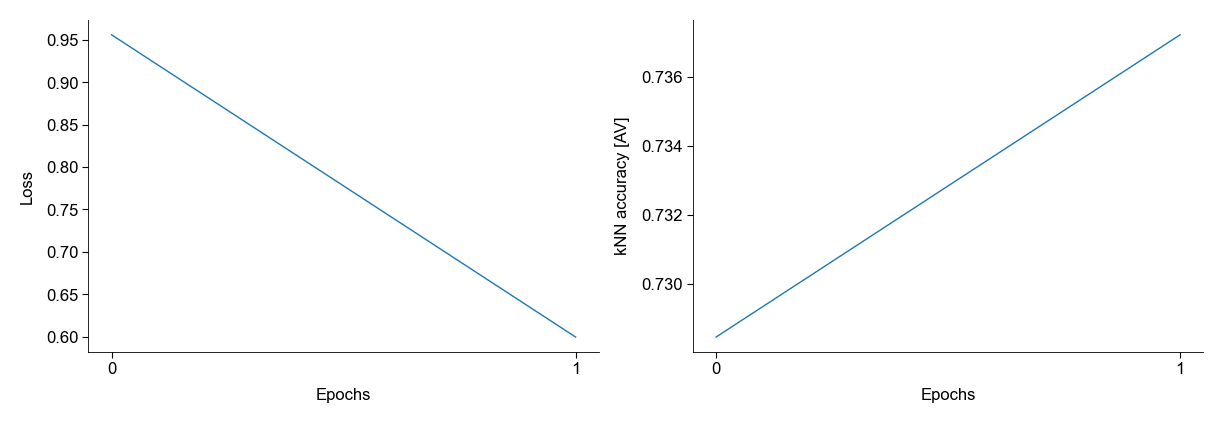

In [ ]:
%matplotlib inline
n_epochs = 2

fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

Text(0, 0.5, 'kNN accuracy [AV]')

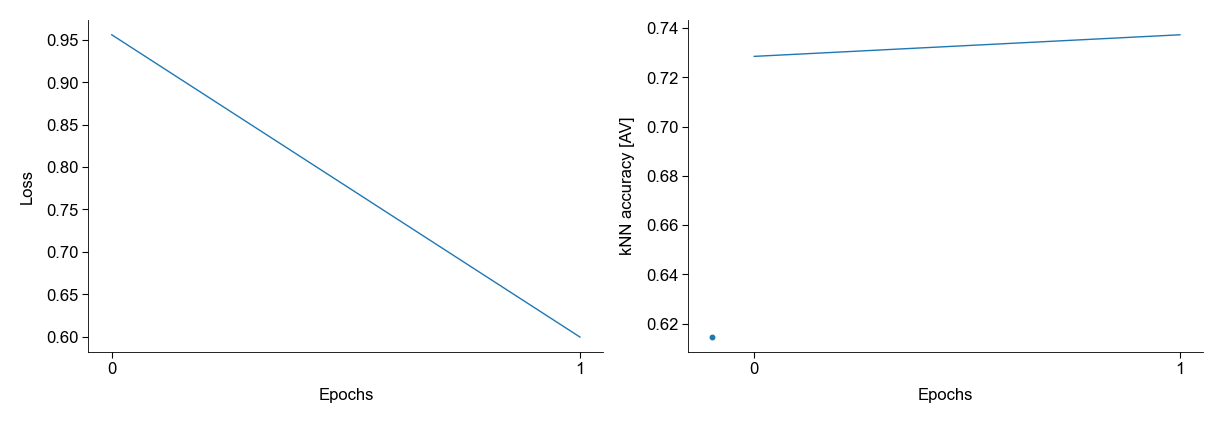

In [ ]:
%matplotlib inline
n_epochs = 2
last_frozen_layer = 11
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

losses = np.load(variables_path / saving_path / "losses_all_unfrozen_v1.npy")
knn_accuracies = np.load(
    variables_path / saving_path / "knn_accuracies_all_unfrozen_v1.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].scatter(-0.1, knn_acc_highd[0], c="tab:blue", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

### Freezing all but layer 12

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
last_frozen_layer = 11  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
modules = [
    model.embeddings,
    *model.encoder.layer[:last_frozen_layer],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_v1"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_" + str(last_frozen_layer) + "_v1"
)

np.save(variables_path / saving_path / saving_name_losses, losses)
np.save(
    variables_path / saving_path / saving_name_accuracies,
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.token_type_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.self.query.weight: False
encoder.layer.0.attention.self.query.bias: False
encoder.layer.0.attention.self.key.weight: False
encoder.layer.0.attention.self.key.bias: False
encoder.layer.0.attention.self.value.weight: False
encoder.layer.0.attention.self.value.bias: False
encoder.layer.0.attention.output.dense.weight: False
encoder.layer.0.attention.output.dense.bias: False
encoder.layer.0.attention.output.LayerNorm.weight: False
encoder.layer.0.attention.output.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encode

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
# # check that you actually froze the layer
# print("After training -------------------")
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

Text(0, 0.5, 'kNN accuracy [AV]')

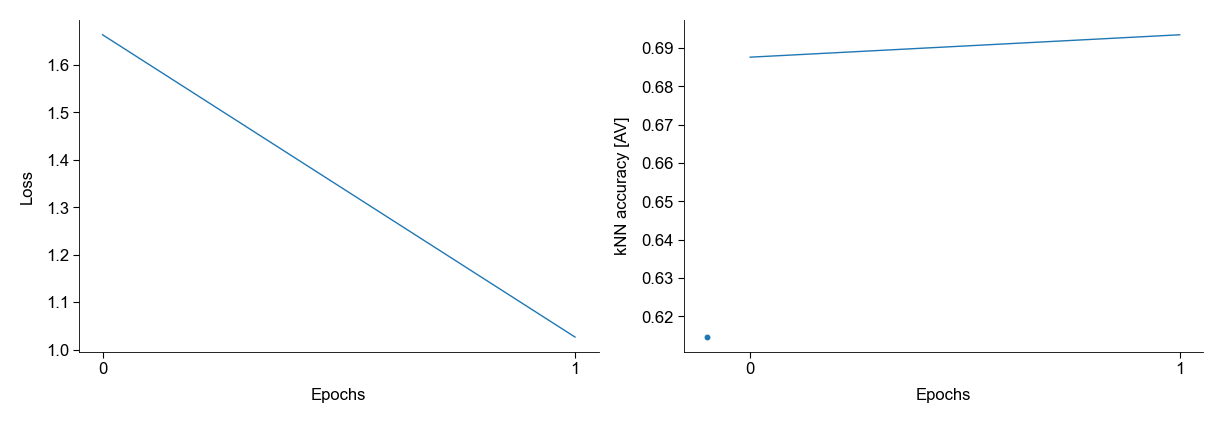

In [ ]:
%matplotlib inline
n_epochs = 2
last_frozen_layer = 11
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)

losses = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies = np.load(variables_path / saving_path / saving_name_accuracies)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].scatter(-0.1, knn_acc_highd[0], c="tab:blue", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

### Freezing until layer 6 (included)

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
last_frozen_layer = 6  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
modules = [
    model.embeddings,
    *model.encoder.layer[:last_frozen_layer],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_v1"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_" + str(last_frozen_layer) + "_v1"
)

np.save(variables_path / saving_path / saving_name_losses, losses)
np.save(
    variables_path / saving_path / saving_name_accuracies,
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.token_type_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.self.query.weight: False
encoder.layer.0.attention.self.query.bias: False
encoder.layer.0.attention.self.key.weight: False
encoder.layer.0.attention.self.key.bias: False
encoder.layer.0.attention.self.value.weight: False
encoder.layer.0.attention.self.value.bias: False
encoder.layer.0.attention.output.dense.weight: False
encoder.layer.0.attention.output.dense.bias: False
encoder.layer.0.attention.output.LayerNorm.weight: False
encoder.layer.0.attention.output.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encode

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
# # check that you actually froze the layer
# print("After training -------------------")
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

Text(0, 0.5, 'kNN accuracy [AV]')

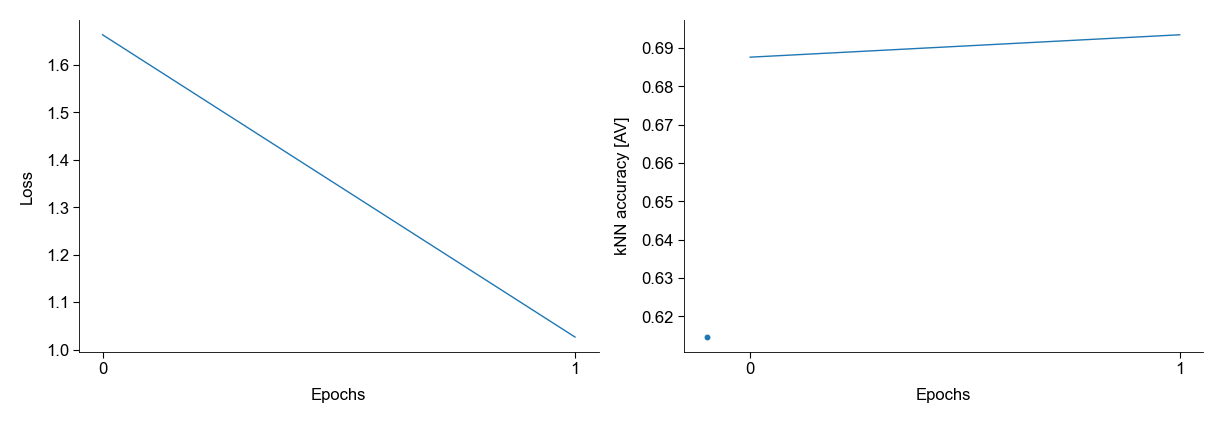

In [ ]:
%matplotlib inline
n_epochs = 2
last_frozen_layer = 6
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)

losses = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies = np.load(variables_path / saving_path / saving_name_accuracies)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].scatter(-0.1, knn_acc_highd[0], c="tab:blue", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

### Freezing first layer but not embedding

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
last_frozen_layer = 1  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
modules = [
    # model.embeddings,
    *model.encoder.layer[:last_frozen_layer],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_unfrozen_embdd_v1"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1"
)

np.save(variables_path / saving_path / saving_name_losses, losses)
np.save(
    variables_path / saving_path / saving_name_accuracies,
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: False
encoder.layer.0.attention.self.query.bias: False
encoder.layer.0.attention.self.key.weight: False
encoder.layer.0.attention.self.key.bias: False
encoder.layer.0.attention.self.value.weight: False
encoder.layer.0.attention.self.value.bias: False
encoder.layer.0.attention.output.dense.weight: False
encoder.layer.0.attention.output.dense.bias: False
encoder.layer.0.attention.output.LayerNorm.weight: False
encoder.layer.0.attention.output.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.lay

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
# # check that you actually froze the layer
# print("After training -------------------")
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

Text(0, 0.5, 'kNN accuracy [AV]')

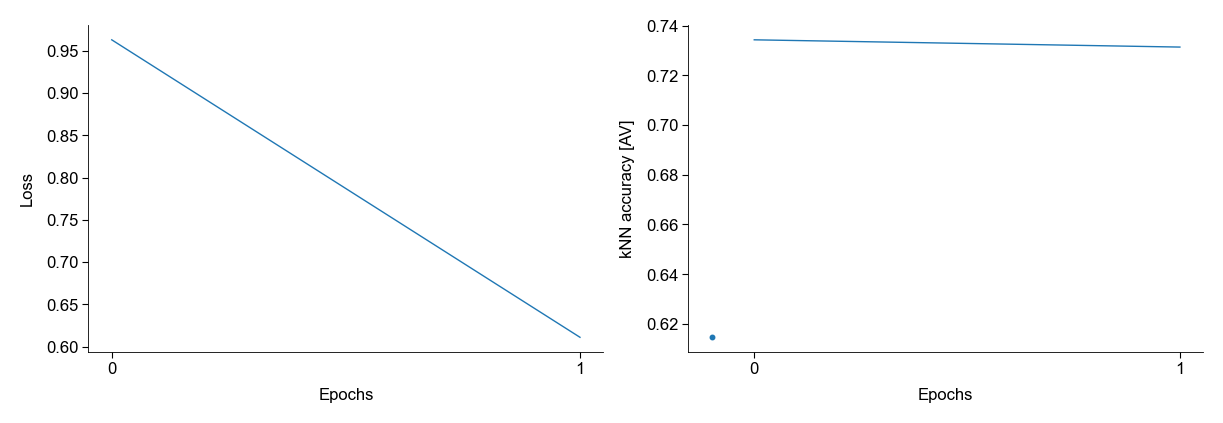

In [ ]:
%matplotlib inline
n_epochs = 2
last_frozen_layer = 1
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)

losses = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies = np.load(variables_path / saving_path / saving_name_accuracies)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].scatter(-0.1, knn_acc_highd[0], c="tab:blue", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

### Freezing only last layer but not embedding

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
frozen_layer = 11  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
modules = [
    # model.embeddings,
    *model.encoder.layer[frozen_layer:],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_frozen_layer_" + str(frozen_layer + 1) + "_unfrozen_embdd_v1"
)
saving_name_accuracies = Path(
    "knn_accuracies_frozen_layer_"
    + str(frozen_layer + 1)
    + "_unfrozen_embdd_v1"
)

np.save(variables_path / saving_path / saving_name_losses, losses)
np.save(
    variables_path / saving_path / saving_name_accuracies,
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.Lay

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
# # check that you actually froze the layer
# print("After training -------------------")
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

Text(0, 0.5, 'kNN accuracy [AV]')

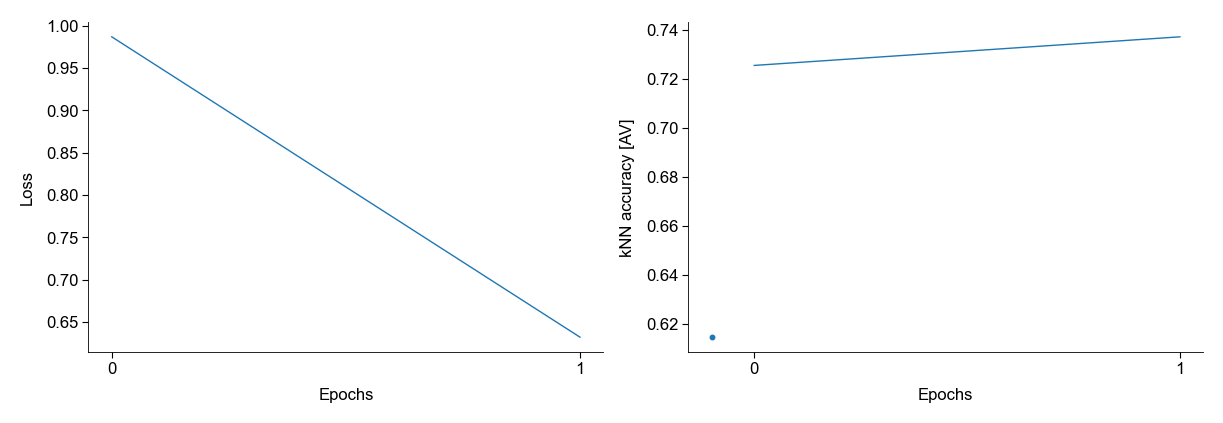

In [ ]:
%matplotlib inline
n_epochs = 2
frozen_layer = 11
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_frozen_layer_" + str(frozen_layer + 1) + "_unfrozen_embdd_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_frozen_layer_"
    + str(frozen_layer + 1)
    + "_unfrozen_embdd_v1.npy"
)

losses = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies = np.load(variables_path / saving_path / saving_name_accuracies)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].scatter(-0.1, knn_acc_highd[0], c="tab:blue", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

### Freezing until layer 6 but not embedding

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
last_frozen_layer = 6  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
modules = [
    # model.embeddings,
    *model.encoder.layer[:last_frozen_layer],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_unfrozen_embdd_v1"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1"
)

np.save(variables_path / saving_path / saving_name_losses, losses)
np.save(
    variables_path / saving_path / saving_name_accuracies,
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.token_type_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.self.query.weight: False
encoder.layer.0.attention.self.query.bias: False
encoder.layer.0.attention.self.key.weight: False
encoder.layer.0.attention.self.key.bias: False
encoder.layer.0.attention.self.value.weight: False
encoder.layer.0.attention.self.value.bias: False
encoder.layer.0.attention.output.dense.weight: False
encoder.layer.0.attention.output.dense.bias: False
encoder.layer.0.attention.output.LayerNorm.weight: False
encoder.layer.0.attention.output.LayerNorm.bias: False
encoder.layer.0.intermediate.dense.weight: False
encoder.layer.0.intermediate.dense.bias: False
encoder.layer.0.output.dense.weight: False
encoder.layer.0.output.dense.bias: False
encoder.layer.0.output.LayerNorm.weight: False
encoder.lay

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
# # check that you actually froze the layer
# print("After training -------------------")
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

Text(0, 0.5, 'kNN accuracy [AV]')

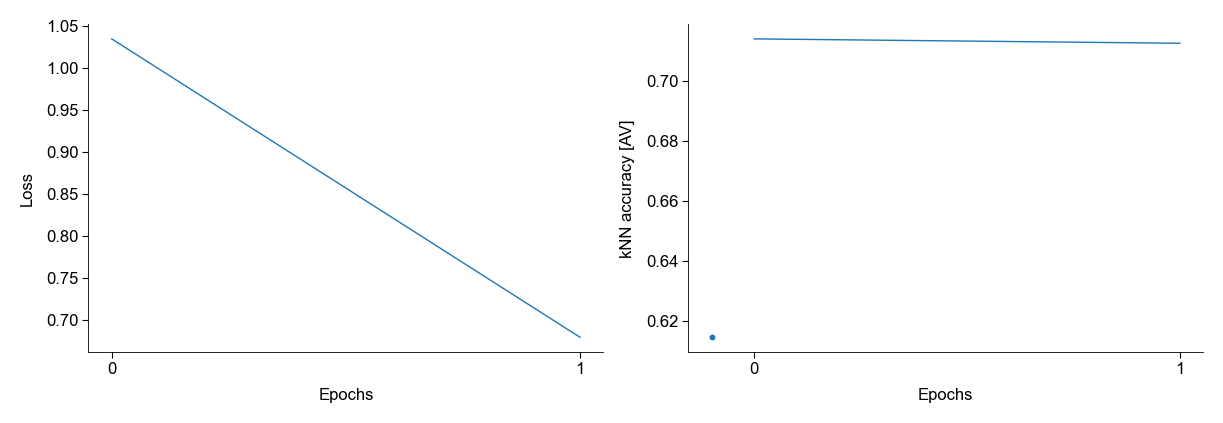

In [ ]:
%matplotlib inline
n_epochs = 2
last_frozen_layer = 6
## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path(
    "losses_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)

losses = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies = np.load(variables_path / saving_path / saving_name_accuracies)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(np.arange(n_epochs), np.mean(losses, axis=1))
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(np.arange(n_epochs), knn_accuracies[:, 0])
ax[1].scatter(-0.1, knn_acc_highd[0], c="tab:blue", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")

### Freezing only embedding

In [ ]:
%%time

## set random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)


## initialize model and tokenizer
i = 0
print("Model : ", model_names[i])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])


## freeze layers
# last_frozen_layer = 6  # layers start at 0, so layer 11 in the model output corresponds to 12, and layer 11 of the model won't be frozen in this case
modules = [
    model.embeddings,
    # *model.encoder.layer[:last_frozen_layer],
]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False
# check that you actually froze the layer
print("Before training -------------------")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

## training data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr.abstract, tokenizer, device, n_cons_sntcs=2
)
gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)

## trainning
losses, knn_accuracies = train_loop(
    model,
    training_loader,
    device,
    titles_abstracts_together,
    tokenizer,
    labeled,
    labels_acc=iclr_labeled["y"].to_numpy(),
    n_epochs=2,
    lr=2e-5,
    return_seventh=True,
)

## save losses and accuracies
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

saving_name_losses = Path("losses_frozen_embdd_v1")
saving_name_accuracies = Path("knn_accuracies_frozen_embdd_v1")

np.save(variables_path / saving_path / saving_name_losses, losses)
np.save(
    variables_path / saving_path / saving_name_accuracies,
    knn_accuracies,
)

Model :  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Before training -------------------
embeddings.word_embeddings.weight: False
embeddings.position_embeddings.weight: False
embeddings.token_type_embeddings.weight: False
embeddings.LayerNorm.weight: False
embeddings.LayerNorm.bias: False
encoder.layer.0.attention.self.query.weight: True
encoder.layer.0.attention.self.query.bias: True
encoder.layer.0.attention.self.key.weight: True
encoder.layer.0.attention.self.key.bias: True
encoder.layer.0.attention.self.value.weight: True
encoder.layer.0.attention.self.value.bias: True
encoder.layer.0.attention.output.dense.weight: True
encoder.layer.0.attention.output.dense.bias: True
encoder.layer.0.attention.output.LayerNorm.weight: True
encoder.layer.0.attention.output.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.outpu

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Plot all

In [ ]:
# import all
saving_path = Path(
    "embeddings_" + model_names[i].lower() + "/freezing_experiment"
)
(variables_path / saving_path).mkdir(exist_ok=True)

## 1
losses_1 = np.load(variables_path / saving_path / "losses_all_unfrozen_v1.npy")
knn_accuracies_1 = np.load(
    variables_path / saving_path / "knn_accuracies_all_unfrozen_v1.npy"
)
## 2
last_frozen_layer = 6
saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)
losses_2 = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies_2 = np.load(
    variables_path / saving_path / saving_name_accuracies
)

## 3
last_frozen_layer = 11
saving_name_losses = Path(
    "losses_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_" + str(last_frozen_layer) + "_v1.npy"
)
losses_3 = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies_3 = np.load(
    variables_path / saving_path / saving_name_accuracies
)

## 4
last_frozen_layer = 1
saving_name_losses = Path(
    "losses_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)
losses_4 = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies_4 = np.load(
    variables_path / saving_path / saving_name_accuracies
)

## 5
frozen_layer = 11
saving_name_losses = Path(
    "losses_frozen_layer_" + str(frozen_layer + 1) + "_unfrozen_embdd_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_frozen_layer_"
    + str(frozen_layer + 1)
    + "_unfrozen_embdd_v1.npy"
)

losses_5 = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies_5 = np.load(
    variables_path / saving_path / saving_name_accuracies
)

## 6
last_frozen_layer = 6
saving_name_losses = Path(
    "losses_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)
saving_name_accuracies = Path(
    "knn_accuracies_last_frozen_layer_"
    + str(last_frozen_layer)
    + "_unfrozen_embdd_v1.npy"
)
losses_6 = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies_6 = np.load(
    variables_path / saving_path / saving_name_accuracies
)

## 7
saving_name_losses = Path("losses_frozen_embdd_v1.npy")
saving_name_accuracies = Path("knn_accuracies_frozen_embdd_v1.npy")
losses_7 = np.load(variables_path / saving_path / saving_name_losses)
knn_accuracies_7 = np.load(
    variables_path / saving_path / saving_name_accuracies
)

saving_name_2 = Path("knn_accuracy_" + model_names[0].lower() + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)

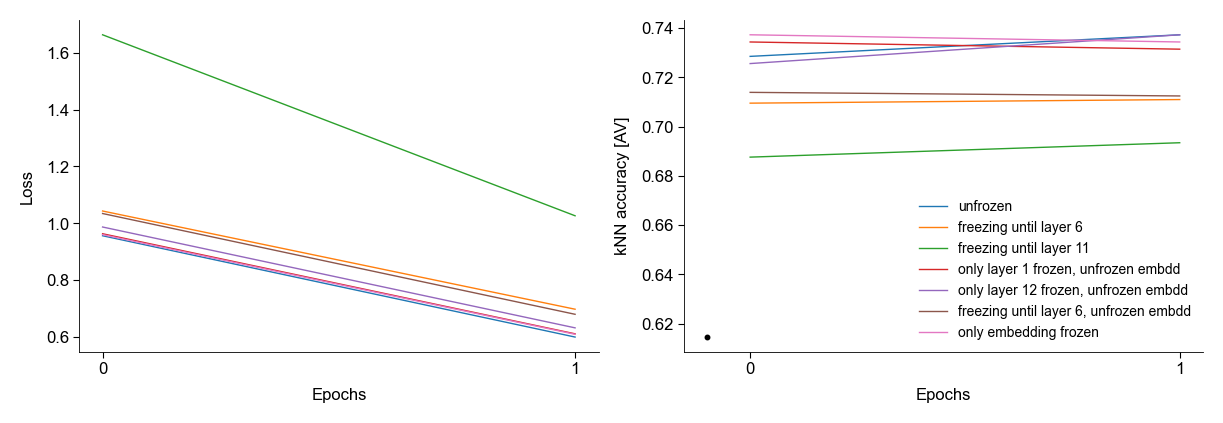

In [ ]:
%matplotlib inline
n_epochs = 2


fig, ax = plt.subplots(1, 2, figsize=(6, 2), dpi=200)

ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_1, axis=1),
    # color="tab:blue",
    label="unfrozen",
)
ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_2, axis=1),
    # color="tab:orange",
    label="freezing until layer 6",
)
ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_3, axis=1),
    # color="tab:green",
    label="freezing until layer 11",
)
ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_4, axis=1),
    # color="tab:blue",
    label="freezing until layer 1, no embdd",
)
ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_5, axis=1),
    # color="tab:orange",
    label="only layer 12 frozen, no embdd",
)
ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_6, axis=1),
    # color="tab:green",
    label="freezing until layer 6, no embdd",
)
ax[0].plot(
    np.arange(n_epochs),
    np.mean(losses_7, axis=1),
    # color="tab:green",
    label="only embedding frozen",
)
ax[0].set_xticks(np.arange(n_epochs))
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")


ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_1[:, 0],
    # color="tab:blue",
    label="unfrozen",
)
ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_2[:, 0],
    # color="tab:orange",
    label="freezing until layer 6",
)
ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_3[:, 0],
    # color="tab:green",
    label="freezing until layer 11",
)
ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_4[:, 0],
    # color="tab:blue",
    label="only layer 1 frozen, unfrozen embdd",
)
ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_5[:, 0],
    # color="tab:orange",
    label="only layer 12 frozen, unfrozen embdd",
)
ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_6[:, 0],
    # color="tab:green",
    label="freezing until layer 6, unfrozen embdd",
)
ax[1].plot(
    np.arange(n_epochs),
    knn_accuracies_7[:, 0],
    # color="tab:green",
    label="only embedding frozen",
)
ax[1].scatter(-0.1, knn_acc_highd[0], c="k", s=5)
ax[1].set_xticks(np.arange(n_epochs))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("kNN accuracy [AV]")
ax[1].legend()

fig.savefig(
    figures_path / "losses_and_accuracies_bert_freezing_experiment_v2.png"
)